In [1]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")

In [2]:
talks_df = pd.read_pickle("/home/p1dg/retrival_bot/data/talks_dataset.df")
talks_df.sample(10)

,Season,Episode,speaker,query,companions,close_reply,neutral_reply,bad_reply,context
7215,Season 3,Episode 1,tyrion lannister,How much?,"[tyrion lannister, bronn, tyrion lannister, br...","[Because you're my friend., I like you, pamper...","[The Queen in the North!, After a long consult...",[A man has a thirst. The man does not drink fo...,You might be surprised. A Lannister always pay...
22101,Season 7,Episode 7,bronn,Come on! You can suck his magic cock later.,[],[],"[Where's that?, You're what?, What's out there?]","[You don't need to see this., I'd forgot the d...",
16447,Season 5,Episode 8,qyburn,"Your arrest, and Queen Margaery's arrest, the ...",[],[],"[You need to talk to him, you need to talk to ...","[Yes, all Lannisters are lions. And when a Tyr...",
1650,Season 1,Episode 5,robert baratheon,And if he's right? If she has a son? A Targary...,"[varys, petyr baelish, varys, petyr baelish]",[l must be one of the few men in this city who...,[The Narrow Sea still lies between us. I'll fe...,"[I'll build that fire., Maybe she's flown some...",To hell with all of you.. When the sun rises i...
21618,Season 7,Episode 5,jaime lannister,I seem to recall them giving you a bit of trou...,[],[],"[And here I am ready to train., You were told ...","[You don't buy them, you only rent them., One ...",
16492,Season 5,Episode 8,tyrion lannister,"So here we sit, two terrible children of two t...",[],[],"[I'm terrible?, It's a terrible thing to do to...","[Run!, I don't care., Any advice?]",
22708,Season 8,Episode 1,daenerys targaryen,Of course.,[],[],"[The Queen in the North!, After a long consult...",[You'll get 50. Lord Baelish will see it paid ...,
677,Season 1,Episode 3,joffrey lannister,I'd crush them. Seize Winterfell and install s...,"[eddard stark, petyr baelish, eddard stark, va...",[You'll get 50. Lord Baelish will see it paid ...,"[And these 10,000 northern troops, would they ...","[You don't want Balon Greyjoy for an ally., We...",I had no money and an expensive wife.. And whe...
21358,Season 7,Episode 4,jaime lannister,Come on!,[],[],"[The Queen in the North!, After a long consult...","[I'd say my parts are mixed, my lady, good and...",
23231,Season 8,Episode 3,varys,At least we're already in a crypt.,[],[],[What? Remember the Battle of Blackwater? I br...,[Staying in the Kingsguard means I live right ...,


In [3]:
import datasets

talk_dataset = {"premise": [], "hypothesis": [], "label": []}

LIMIT_CONTEXT = 200

cols = ["query", "close_reply", "neutral_reply", "bad_reply", "context"]
for index, row in talks_df[cols].iterrows():
    close_reply = row["close_reply"]
    neutral_reply = row["neutral_reply"]
    bad_reply = row["bad_reply"]

    hypothesis = close_reply + neutral_reply + bad_reply
    labels = (
        [1 for _ in range(len(close_reply))]
        + [0 for _ in range(len(neutral_reply))]
        + [2 for _ in range(len(bad_reply))]
    )

    premise = [
        row["query"] + "[SEP]" + row["context"][:LIMIT_CONTEXT]
        for _ in range(len(hypothesis))
    ]

    if len(premise) != len(labels) != len(hypothesis):
        print(f"mistake with row {index}")
        break

    else:
        talk_dataset["premise"].extend(premise)
        talk_dataset["hypothesis"].extend(hypothesis)
        talk_dataset["label"].extend(labels)

dataset = datasets.Dataset.from_dict(talk_dataset)

In [4]:
SEED = 10

random.seed(SEED)
np.random.seed(SEED)

filtered_data = []
for data in tqdm(dataset):
    if random.random() < 0.1:
        filtered_data.append(data)
len(filtered_data)

100%|██████████| 109090/109090 [00:01<00:00, 61801.11it/s]


10756

In [5]:
from typing import Callable, Iterable

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoTokenizer, AutoModel
from transformers.optimization import get_linear_schedule_with_warmup
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity

In [6]:
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [7]:
class SnliDataset(Dataset):
    def __init__(
        self, premise_tokens: dict, hypothesis_tokens: dict, labels: Iterable[str]
    ):
        self.premise_tokens = premise_tokens
        self.hypothesis_tokens = hypothesis_tokens
        self.labels = labels
        self._init_data()

    def _init_data(self) -> None:
        self.data = []
        for pt_ids, pt_am, ht_ids, ht_am, label in zip(
            self.premise_tokens["input_ids"],
            self.premise_tokens["attention_mask"],
            self.hypothesis_tokens["input_ids"],
            self.hypothesis_tokens["attention_mask"],
            self.labels,
        ):
            data = {}
            data["premise_input_ids"] = torch.tensor(pt_ids, dtype=torch.long)
            data["premise_attention_mask"] = torch.tensor(pt_am, dtype=torch.long)
            data["hypothesis_input_ids"] = torch.tensor(ht_ids, dtype=torch.long)
            data["hypothesis_attention_mask"] = torch.tensor(ht_am, dtype=torch.long)
            data["label"] = torch.tensor(label, dtype=torch.long)
            self.data.append(data)

    def __getitem__(self, ix: int) -> dict[str, torch.tensor]:
        return self.data[ix]

    def __len__(self) -> int:
        return len(self.data)

In [8]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [9]:
%%time

MAX_LENGTH = 128

tokenized_premises = tokenizer(
    [data["premise"] for data in filtered_data],
    max_length=MAX_LENGTH,
    padding="max_length",
    truncation=True,
    verbose=True,
)

tokenized_hypothesis = tokenizer(
    [data["hypothesis"] for data in filtered_data],
    max_length=MAX_LENGTH,
    padding="max_length",
    truncation=True,
    verbose=True,
)

CPU times: user 2.17 s, sys: 818 ms, total: 2.99 s
Wall time: 1.02 s


In [10]:
snli_dataset = SnliDataset(
    tokenized_premises, tokenized_hypothesis, (data["label"] for data in filtered_data)
)

In [11]:
train_ratio = 0.8
n_total = len(snli_dataset)
n_train = int(n_total * train_ratio)
n_val = n_total - n_train

train_dataset, val_dataset = random_split(snli_dataset, [n_train, n_val])

batch_size = 16  # mentioned in the paper
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [12]:
def mean_pool(token_embeds: torch.tensor, attention_mask: torch.tensor) -> torch.tensor:
    in_mask = attention_mask.unsqueeze(-1).expand(token_embeds.size()).float()
    pool = torch.sum(token_embeds * in_mask, 1) / torch.clamp(in_mask.sum(1), min=1e-9)
    return pool


def encode(
    input_texts: list[str],
    tokenizer: AutoTokenizer,
    model: AutoModel,
    device: str = "cpu",
) -> torch.tensor:
    model.eval()
    tokenized_texts = tokenizer(
        input_texts,
        max_length=128,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )
    token_embeds = model(
        tokenized_texts["input_ids"].to(DEVICE),
        tokenized_texts["attention_mask"].to(device),
    ).last_hidden_state
    pooled_embeds = mean_pool(
        token_embeds, tokenized_texts["attention_mask"].to(DEVICE)
    )
    return pooled_embeds

In [13]:
class Sbert(torch.nn.Module):
    def __init__(self, max_length: int = 128):
        super().__init__()
        self.max_length = max_length
        self.bert_model = AutoModel.from_pretrained("distilbert-base-uncased")
        self.bert_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
        self.linear = torch.nn.Linear(self.bert_model.config.hidden_size * 3, 3)

    def forward(self, data: datasets.arrow_dataset.Dataset) -> torch.tensor:
        premise_input_ids = data["premise_input_ids"].to(DEVICE)
        premise_attention_mask = data["premise_attention_mask"].to(DEVICE)
        hypothesis_input_ids = data["hypothesis_input_ids"].to(DEVICE)
        hypothesis_attention_mask = data["hypothesis_attention_mask"].to(DEVICE)

        out_premise = self.bert_model(premise_input_ids, premise_attention_mask)
        out_hypothesis = self.bert_model(
            hypothesis_input_ids, hypothesis_attention_mask
        )
        premise_embeds = out_premise.last_hidden_state
        hypothesis_embeds = out_hypothesis.last_hidden_state

        pooled_premise_embeds = mean_pool(premise_embeds, premise_attention_mask)
        pooled_hypotheses_embeds = mean_pool(
            hypothesis_embeds, hypothesis_attention_mask
        )

        embeds = torch.cat(
            [
                pooled_premise_embeds,
                pooled_hypotheses_embeds,
                torch.abs(pooled_premise_embeds - pooled_hypotheses_embeds),
            ],
            dim=-1,
        )
        return self.linear(embeds)

In [14]:
PRE_TRAIN_BE_EN = False

bi_encoder = Sbert()

if PRE_TRAIN_BE_EN:
    bi_encoder.bert_model.from_pretrained("/sbert_pretrained")

bi_encoder.to(DEVICE)

Sbert(
  (bert_model): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_f

In [15]:
optimizer = torch.optim.AdamW(bi_encoder.parameters(), lr=2e-6)
total_steps = len(train_dataset) // batch_size
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps - warmup_steps,
)

loss_fn = torch.nn.CrossEntropyLoss()

In [16]:
def get_train_step_fn(
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler.LambdaLR,
    loss_fn: torch.nn.CrossEntropyLoss,
) -> Callable[[torch.tensor, torch.tensor], float]:
    def train_step_fn(x: torch.tensor, y: torch.tensor) -> float:
        model.train()
        yhat = model(x)
        loss = loss_fn(yhat, y)
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        return loss.item()

    return train_step_fn


def get_val_step_fn(
    model: torch.nn.Module, loss_fn: torch.nn.CrossEntropyLoss
) -> Callable[[torch.tensor, torch.tensor], float]:
    def val_step_fn(x: torch.tensor, y: torch.tensor) -> float:
        model.eval()
        yhat = model(x)
        loss = loss_fn(yhat, y)
        return loss.item()

    return val_step_fn


def mini_batch(
    dataloader: DataLoader,
    step_fn: Callable[[torch.tensor, torch.tensor], float],
    is_training: bool = True,
) -> tuple[np.array, list[float]]:
    mini_batch_losses = []

    if is_training:
        print("\nTraining ...")
    else:
        print("\nValidating ...")
    n_steps = len(dataloader)
    for i, data in tqdm(enumerate(dataloader), total=n_steps):
        loss = step_fn(data, data["label"].to(DEVICE))
        mini_batch_losses.append(loss)
        if i % (batch_size * 100) == 0:
            print(f"step {i:>5}/{n_steps}, loss = {loss: .3f}")

    return np.mean(mini_batch_losses), mini_batch_losses

In [17]:
%%time

n_epochs = 15  # mentioned in the paper

train_step_fn = get_train_step_fn(bi_encoder, optimizer, scheduler, loss_fn)
val_step_fn = get_val_step_fn(bi_encoder, loss_fn)

train_losses, train_mini_batch_losses = [], []
val_losses, val_mini_batch_losses = [], []

for epoch in tqdm(range(1, n_epochs + 1)):
    train_loss, _train_mini_batch_losses = mini_batch(train_dataloader, train_step_fn)
    train_mini_batch_losses += _train_mini_batch_losses
    train_losses.append(train_loss)

    with torch.no_grad():
        val_loss, _val_mini_batch_losses = mini_batch(
            val_dataloader, val_step_fn, is_training=False
        )
        val_mini_batch_losses += _val_mini_batch_losses
        val_losses.append(val_loss)

  0%|          | 0/15 [00:00<?, ?it/s]


Training ...


step     0/538, loss =  1.197


100%|██████████| 538/538 [00:53<00:00, 10.08it/s]



Validating ...


step     0/135, loss =  1.024


  7%|▋         | 1/15 [00:58<13:36, 58.29s/it]


Training ...


step     0/538, loss =  1.021


100%|██████████| 538/538 [00:52<00:00, 10.16it/s]



Validating ...


step     0/135, loss =  1.024


 13%|█▎        | 2/15 [01:56<12:34, 58.02s/it]


Training ...


step     0/538, loss =  0.990


100%|██████████| 538/538 [00:52<00:00, 10.16it/s]



Validating ...


step     0/135, loss =  1.024


 20%|██        | 3/15 [02:53<11:35, 57.93s/it]


Training ...


step     0/538, loss =  1.041


100%|██████████| 538/538 [00:52<00:00, 10.16it/s]



Validating ...


step     0/135, loss =  1.024


 27%|██▋       | 4/15 [03:51<10:36, 57.90s/it]


Training ...


step     0/538, loss =  1.069


100%|██████████| 538/538 [00:52<00:00, 10.16it/s]



Validating ...


step     0/135, loss =  1.024


 33%|███▎      | 5/15 [04:49<09:38, 57.89s/it]


Training ...


step     0/538, loss =  1.053


100%|██████████| 538/538 [00:52<00:00, 10.16it/s]



Validating ...


step     0/135, loss =  1.024


 40%|████      | 6/15 [05:47<08:40, 57.88s/it]


Training ...


step     0/538, loss =  1.058


100%|██████████| 538/538 [00:54<00:00,  9.85it/s]



Validating ...


step     0/135, loss =  1.024


 47%|████▋     | 7/15 [06:47<07:47, 58.42s/it]


Training ...


step     0/538, loss =  1.039


100%|██████████| 538/538 [00:54<00:00,  9.88it/s]



Validating ...


step     0/135, loss =  1.024


 53%|█████▎    | 8/15 [07:46<06:51, 58.72s/it]


Training ...


step     0/538, loss =  1.056


100%|██████████| 538/538 [00:53<00:00, 10.10it/s]



Validating ...


step     0/135, loss =  1.024


 60%|██████    | 9/15 [08:44<05:51, 58.56s/it]


Training ...


step     0/538, loss =  1.064


100%|██████████| 538/538 [00:56<00:00,  9.59it/s]



Validating ...


step     0/135, loss =  1.024


 67%|██████▋   | 10/15 [09:46<04:57, 59.53s/it]


Training ...


step     0/538, loss =  1.061


100%|██████████| 538/538 [01:00<00:00,  8.92it/s]



Validating ...


step     0/135, loss =  1.024


 73%|███████▎  | 11/15 [10:51<04:05, 61.39s/it]


Training ...


step     0/538, loss =  1.042


100%|██████████| 538/538 [00:54<00:00,  9.86it/s]



Validating ...


step     0/135, loss =  1.024


 80%|████████  | 12/15 [11:51<03:02, 60.87s/it]


Training ...


step     0/538, loss =  1.041


100%|██████████| 538/538 [01:02<00:00,  8.59it/s]



Validating ...


step     0/135, loss =  1.024


 87%|████████▋ | 13/15 [13:00<02:06, 63.22s/it]


Training ...


step     0/538, loss =  1.001


100%|██████████| 538/538 [01:00<00:00,  8.82it/s]



Validating ...


step     0/135, loss =  1.024


 93%|█████████▎| 14/15 [14:06<01:04, 64.12s/it]


Training ...


step     0/538, loss =  1.044


100%|██████████| 538/538 [00:59<00:00,  9.01it/s]



Validating ...


step     0/135, loss =  1.024


100%|██████████| 15/15 [15:12<00:00, 60.81s/it]

CPU times: user 15min 3s, sys: 10.8 s, total: 15min 14s
Wall time: 15min 12s


In [18]:
last_lr = scheduler.get_lr()[0]
last_lr = round(last_lr, 5)
bi_encoder.bert_model.save_pretrained(f"sbert_softmax_lr_{last_lr}")

In [19]:
window_size = 32

train_mb_running_loss = []
for i in range(len(train_mini_batch_losses) - window_size):
    train_mb_running_loss.append(np.mean(train_mini_batch_losses[i : i + window_size]))

val_mb_running_loss = []
for i in range(len(val_mini_batch_losses) - window_size):
    val_mb_running_loss.append(np.mean(val_mini_batch_losses[i : i + window_size]))

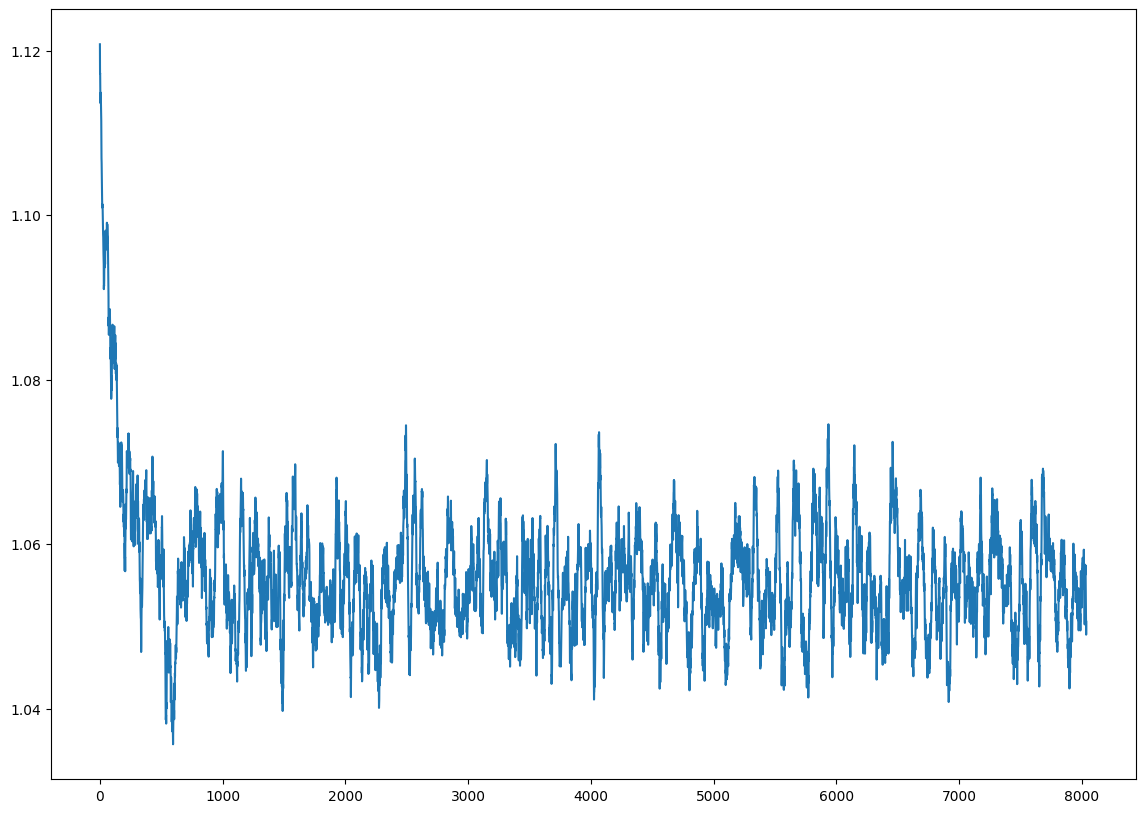

In [20]:
fix, ax = plt.subplots(figsize=(14, 10))
ax.plot(range(len(train_mb_running_loss)), train_mb_running_loss);

In [21]:
def plot_heatmap(similarity_matrix: np.array, sentences: list[str]) -> None:
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(similarity_matrix, cmap="YlGn", interpolation="nearest")

    ax.set_yticks(
        np.arange(len(sentences)), labels=[txt[:50] + "..." for txt in sentences]
    )
    ax.set_xticks(
        np.arange(len(sentences)), labels=[txt[:50] + "..." for txt in sentences]
    )

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    for i in range(len(sentences)):
        for j in range(len(sentences)):
            text = ax.text(
                j,
                i,
                round(similarity_matrix[i, j], 2),
                ha="center",
                va="center",
                color="w",
            )

    fig.tight_layout()
    plt.show()

In [22]:
sentences = [
    "What should I do to improve my English ?",
    "What should I do to improve my spoken English?",
    "Can I improve my English?",
    "How can I earn money online?",
    "How do I earn money online?",
    "Can I earn money online?",
    "What are some mind-blowing Mobile gadgets that exist that most people don't know about?",
    "What are some mind-blowing gadgets and technologies that exist that most people don't know about?",
    "What are some mind-blowing mobile technology tools that exist that most people don't know about?",
]

In [23]:
pooled_embeds = encode(
    sentences, bi_encoder.bert_tokenizer, bi_encoder.bert_model, DEVICE
)
pooled_embeds = pooled_embeds.cpu().detach().numpy()

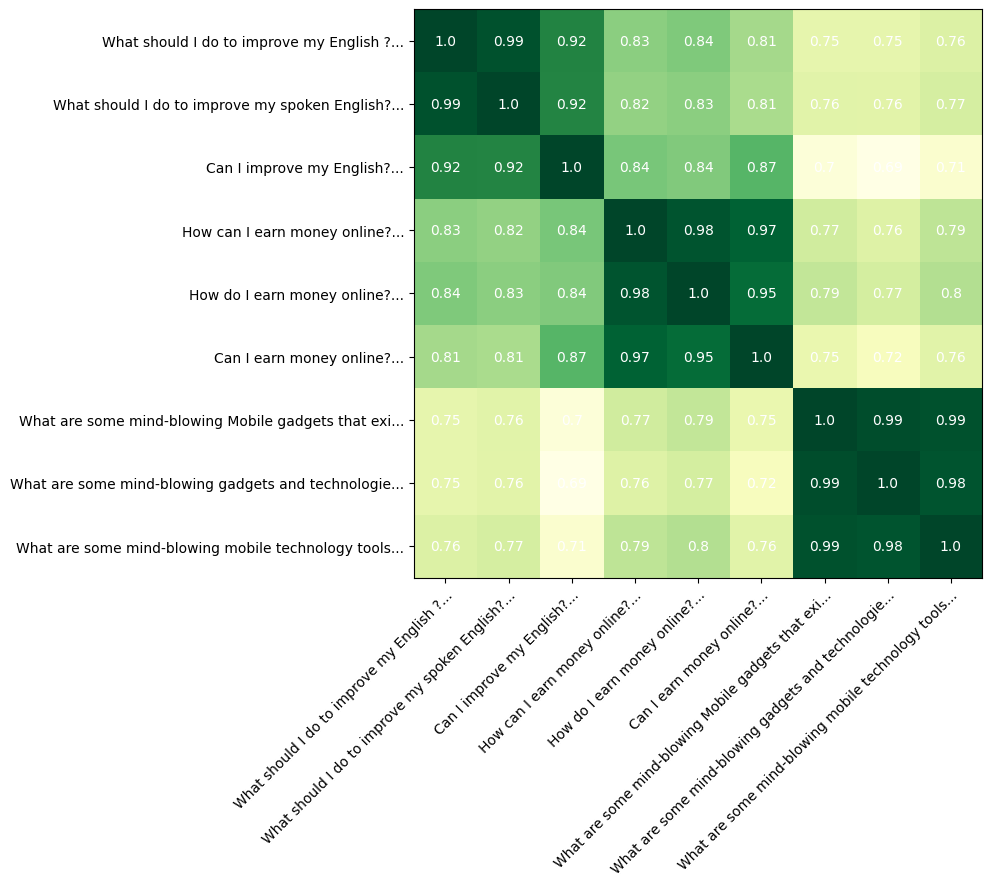

In [24]:
similarity_matrix = cosine_similarity(pooled_embeds)
plot_heatmap(similarity_matrix, sentences)

In [25]:
def flush_memory():
    import gc

    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    with torch.no_grad():
        for _ in range(3):
            torch.cuda.empty_cache()
            torch.cuda.ipc_collect()

In [26]:
def bert_predict(
    question,
    context,
    corpus,
    tokenizer,
    model,
    device,
    size_patch=150,
    qty_rand_choose=5,
    max_out_context=200,
):
    dic_answ = dict()
    dic_answ["score"] = []
    dic_answ["answer"] = []

    conext_memory = question + "[SEP]" + context

    if len(corpus) < qty_rand_choose * max_out_context:
        qty_rand_choose = int(len(corpus))
    # так как база бо
    for i in range(qty_rand_choose):
        rand_patch = list(np.random.choice(corpus, size_patch))

        pooled_embeds = encode([conext_memory] + rand_patch, tokenizer, model, device)

        pooled_embeds = pooled_embeds.cpu().detach().numpy()
        cos_sim = cosine_similarity(pooled_embeds)[0][1:]
        idx = cosine_similarity(pooled_embeds)[0][1:].argmax()
        dic_answ["score"].append(cos_sim[idx])
        dic_answ["answer"].append(rand_patch[idx])

    id = np.array(dic_answ["score"]).argmax()
    answer = dic_answ["answer"][id]
    conext_memory = answer + "[SEP]" + conext_memory
    flush_memory()
    return answer, conext_memory[:max_out_context], dic_answ["score"][id]

In [27]:
# Соберем все ответы из базы
base_answers = talks_df["close_reply"].values
all_replies = []
for rep in base_answers.tolist():
    all_replies.extend(rep)
all_replies = list(set(all_replies))  # Список всех ответов из базы

In [28]:
question = "What is the live?"  #
print(f"Реплика: {question}")

best_answer, conext_memory, best_score = bert_predict(
    question, "", all_replies, bi_encoder.bert_tokenizer, bi_encoder.bert_model, DEVICE
)

print(f"Лучший ответ: {best_answer}\nс вероятностью релевантности {best_score}")

Реплика: What is the live?
Лучший ответ: Who better?
с вероятностью релевантности 0.8691836595535278


In [29]:
question = "What is the live?"  #
print(f"Реплика: {question}")

best_answer, conext_memory, best_score = bert_predict(
    question,
    conext_memory,
    all_replies,
    bi_encoder.bert_tokenizer,
    bi_encoder.bert_model,
    DEVICE,
)

print(f"Лучший ответ: {best_answer}\nс вероятностью релевантности {best_score}")

Реплика: What is the live?
Лучший ответ: Learn what?
с вероятностью релевантности 0.855234682559967


In [30]:
rand_questions = talks_df.sample(10)["query"].values

for i, question in enumerate(rand_questions):
    print(f"Реплика: {question}")
    if not i:
        conext_memory = ""
    best_answer, conext_memory, best_score = bert_predict(
        question,
        conext_memory,
        all_replies,
        bi_encoder.bert_tokenizer,
        bi_encoder.bert_model,
        DEVICE,
    )
    best_score = round(float(best_score), 3)
    print(f"Ответ: {best_answer}\n score {best_score}\n")

Реплика: He would have killed you and cut Bran's throat.
Ответ: I don't want Cersei to murder me either. I could have stayed in my cell and saved a great deal of trouble.
 score 0.85

Реплика: A needle.
Ответ: I do not fight for the Boltons. I'm Brienne of Tarth. I was Kingsguard to Renly Baratheon. I was there when he was murdered by a shadow with your face. You murdered him? With blood magic?
 score 0.897

Реплика: For a short time
Ответ: Forgive me, Ser Davos. I never did receive a formal education, but I could have sworn the last King in the North was Torren Stark who bent the knee to my ancestor Aegon Targaryen in exchange for his life and the lives of the northmen. Torren Stark swore fealty to House Targaryen in perpetuity. But do I have my facts wrong?
 score 0.913

Реплика: You mutilated him. You gave me your word.
Ответ: Do you know, I've never been with any woman but Cersei. So in my own way, I have more honor than poor old dead Ned. What was the name of that bastard he fathe